In [1]:
# Sentiment Analysis using

In [2]:
# Dataset that I have used is as the IMDb dataset. 
# It consists of movie reviews from the website imdb.com, each labeled as either 'positive', 
# if the reviewer enjoyed the film, or 'negative' otherwise.

import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [3]:
# Let's look at one of the positive & negative reviews:
print(data['train']['pos'][2]) # positive
print(data['train']['neg'][2]) # negative

A solid, if unremarkable film. Matthau, as Einstein, was wonderful. My favorite part, and the only thing that would make me go out of my way to see this again, was the wonderful scene with the physicists playing badmitton, I loved the sweaters and the conversation while they waited for Robbins to retrieve the birdie.
Ouch! This one was a bit painful to sit through. It has a cute and amusing premise, but it all goes to hell from there. Matthew Modine is almost always pedestrian and annoying, and he does not disappoint in this one. Deborah Kara Unger and John Neville turned in surprisingly decent performances. Alan Bates and Jennifer Tilly, among others, played it way over the top. I know that's the way the parts were written, and it's hard to blame actors, when the script and director have them do such schlock. If you're going to have outrageous characters, that's OK, but you gotta have good material to make it work. It didn't here. Run away screaming from this movie if at all possible.

In [4]:
print(data['train']['neg'][2]) # negative

Ouch! This one was a bit painful to sit through. It has a cute and amusing premise, but it all goes to hell from there. Matthew Modine is almost always pedestrian and annoying, and he does not disappoint in this one. Deborah Kara Unger and John Neville turned in surprisingly decent performances. Alan Bates and Jennifer Tilly, among others, played it way over the top. I know that's the way the parts were written, and it's hard to blame actors, when the script and director have them do such schlock. If you're going to have outrageous characters, that's OK, but you gotta have good material to make it work. It didn't here. Run away screaming from this movie if at all possible.


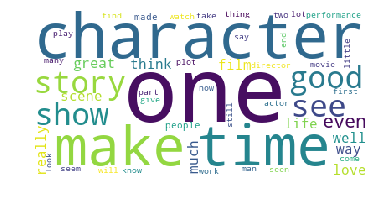

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

In [6]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # TODO: Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    # TODO: Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


In [7]:
# Preprocessing 

# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pradeepsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    text = BeautifulSoup(review, "html5lib").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]

    # Return final list of words
    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

In [9]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Wrote preprocessed data to cache file: preprocessed_data.pkl

--- Raw review ---
Kid found as a baby in the garbage and raised at a martial arts academy has a knack for sinking baskets. With the help of the man who found him he gets in to college and is promoted to the championship as he searches for his real parents. Infinitely better in pieces action comedy is a real mess as a whole. It seems to be striving for a hipper basketball version of Shaolin Soccer, but the comedy is scatter shot, its focus wanders more than a Chihuahua with ADD on quadruple espresso. I kept asking "What am I watching". I watched it from start to finish and I still don't know what the hell happened. Its a shame since there are some great action scenes, some amusing jokes and the occasional moment, but nothing, none of it ever comes together, I'd take a pass.

--- Preprocessed words ---
['kid', 'found', 'babi', 'garbag', 'rais', 'martial', 'art', 'academi', 'knack', 'sink', 'basket', 'help', 'man', 'found', 'g

In [10]:
## Extracting Bag-of-Words features

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # TODO: Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['lemmon', 'food', 'lust', 'trick', 'mixtur', 'ian', 'awhil', 'attack']

--- Preprocessed words ---
['genius', 'william', 'cameron', 'menzi', 'herbert', 'georg', 'well', 'craft', 'extraordinari', 'anticip', 'film', 'ambit', 'scope', 'hard', 'find', 'today', 'predict', 'world', 'war', 'ii', 'way', 'great', 'britain', 'attack', 'also', 'fact', 'war', 'would', 'follow', 'space', 'race', 'chang', 'time', 'film', 'war', 'space', 'explor', 'much', 'longer', 'mani', 'qualit', 'correct', 'thing', 'amaz', 'even', 'see', 'helicopt', 'film', 'older', 'unforgett', 'giant', 'plane', 'futurist', 'meritocraci', 'scientist', 'seem', 'roman', 'bubbl', 'helmet', 'see', 'funni', 'costum', 'may', 'appreci', 'state', 'art', 'architectur', 'master', '30', 'well', 'vision', 'rationalist', 'societi', 'interest', 'reflect', 'natur', 'power', 'john', 'cabal', 'archetyp', 'adventur', 'invent', 'human', 'one', 'choos', 'shape', 'r

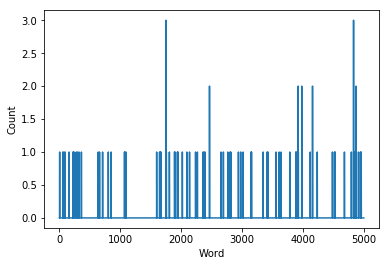

In [12]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

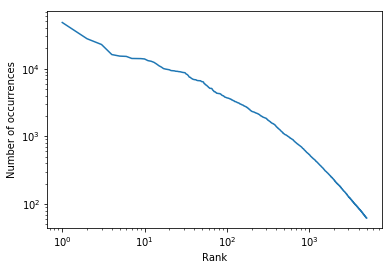

In [13]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [14]:
# Normalize feature vectors
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

In [15]:
# Classification using BoW features

In [16]:
from sklearn.naive_bayes import GaussianNB

# TODO: Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.72768


In [17]:
# Gradient-Boosted Decision Tree classifier

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    clf.fit(X_train, y_train)

    # TODO(optional): Perform hyperparameter tuning / model selection
    
    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.79472, test = 0.79004


In [19]:
# Adverserial testing

In [20]:
# TODO: Write a sample review and set its true sentiment
my_review = "I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end."
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# TODO: Apply the same preprocessing and vectorizing steps as you did for your training data
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
my_bow_features = vectorizer.transform([my_words]).toarray()  # pass an array of 1 element

# TODO: Then call your classifier to label it
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, predicted_sentiment))

--- My review ---
I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end.

--- Preprocessed words ---
['thought', 'would', 'like', 'bore', 'sequel', 'come', 'everyday', 'gone', 'would', 'miss', 'treat', 'bore', 'kept', 'edg', 'seat', 'till', 'end']

True sentiment: pos, predicted sentiment: neg
